<a href="https://colab.research.google.com/github/yxmauw/GA_Capstone/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="http://imgur.com/1ZcRyrc.png" width="70" height="70" align="left" style="margin: 20px"> 
 # Capstone: Glaucoma detection using Fundoscopy images

In [1]:
import tensorflow as tf
print(tf.__version__) #2.8.2

2.8.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [3]:
# upload files to working directory each runtime
!git clone https://github.com/yxmauw/GA_Capstone.git # has to be public repository

Cloning into 'GA_Capstone'...
remote: Enumerating objects: 827, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 827 (delta 96), reused 120 (delta 67), pack-reused 660
Receiving objects: 100% (827/827), 213.18 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Checking out files: 100% (656/656), done.


In [4]:
all_labels = pd.read_csv('./GA_Capstone/glaucoma_labels.csv') # this works which is weird
all_labels.head(3)

Filename  ExpCDR Eye Set  Glaucoma
0  001.jpg  0.7097  OD   A         0
1  002.jpg  0.6953  OS   A         0
2  003.jpg  0.9629  OS   A         0

In [5]:
# explore counts
all_labels['Glaucoma'].value_counts()
# 482 negative, 168 positive for glaucoma (contains both train, validation images)
# unbalanced data
# total 650 images

0    482
1    168
Name: Glaucoma, dtype: int64

In [6]:
import fnmatch
import os

# image files count
train_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Negative'), '*.jpg'))
train_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive'), '*.jpg'))
test_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Negative'), '*.jpg'))
test_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Positive'), '*.jpg'))
total_image_count = train_g_negative_count + train_g_positive_count + \
                    test_g_negative_count + test_g_positive_count
# print count
print('---Train images---')
print('Glaucoma Negative:', train_g_negative_count)
print('Glaucoma Positive:', train_g_positive_count)
print()
print('---Validation iamges---')
print('Glaucoma Negative:', test_g_negative_count)
print('Glaucoma Positive:', test_g_positive_count)
print()
print('---Total image count---')
print(total_image_count)

---Train images---
Glaucoma Negative: 386
Glaucoma Positive: 134

---Validation iamges---
Glaucoma Negative: 96
Glaucoma Positive: 34

---Total image count---
650


## Explore sample image

In [7]:
# load example image
from PIL import Image 
im = Image.open('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size)

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape) # channel last

JPEG
RGB
(3072, 2048)
[[1 3 0]
 [1 3 0]
 [1 3 0]
 ...
 [1 3 0]
 [1 3 0]
 [1 3 0]]
(2048, 3072, 3)


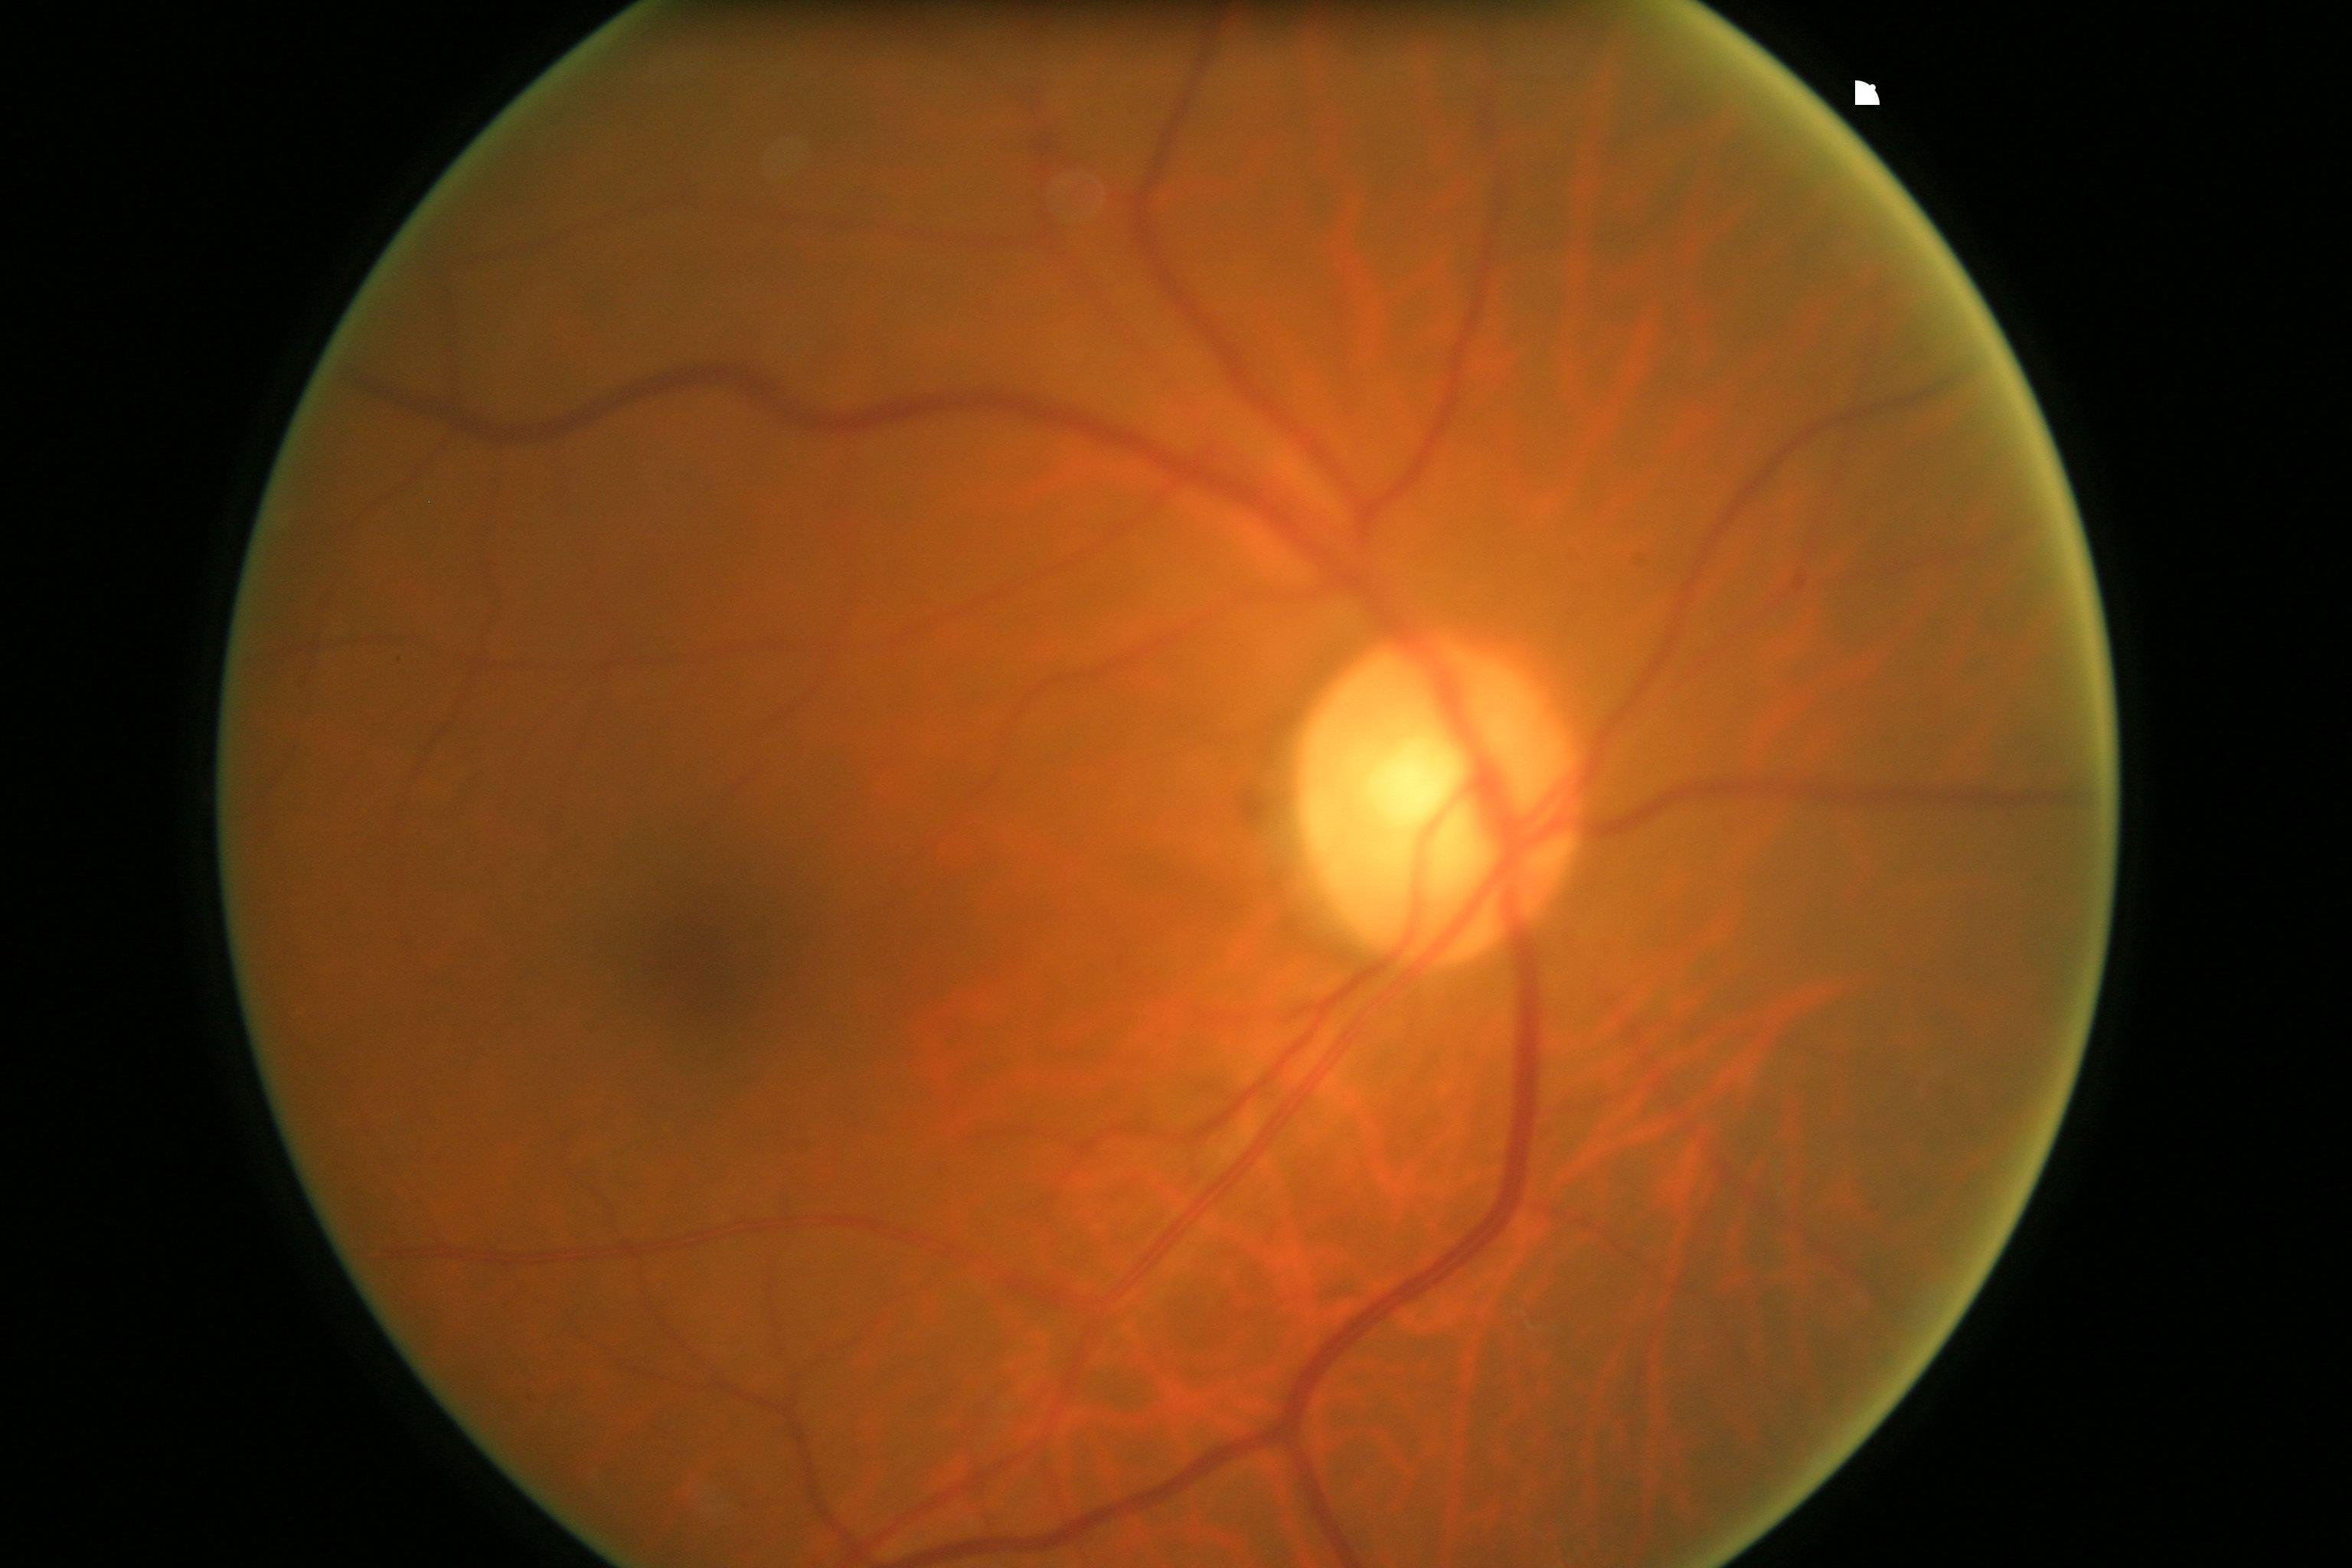

In [8]:
#Import library
from IPython import display
display.Image(filename='./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', width=220, height=150)

In [9]:
# Using one image as example
# calculate image pixel mean, min, max

mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Mean: 63.332
Min: 0.000, Max: 255.000


## Resize and rescale demonstration, visualisation
Later inbuilt into CNN pipeline

In [10]:
# global centering similar to minmaxscaler but for images
# using tf.keras.layers.Resizing and tf.keras.layers.Rescaling

from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([   
    layers.Resizing(150,220) , 
    layers.Rescaling(1./255) # desired height, width in model pipeline
])

result = resize_and_rescale(pixels)
print(result.shape) # new shape, channels # will be configured to be symmetrical in pipeline

(150, 220, 3)


Verify that the pixels are in the [0, 1] range:

In [11]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


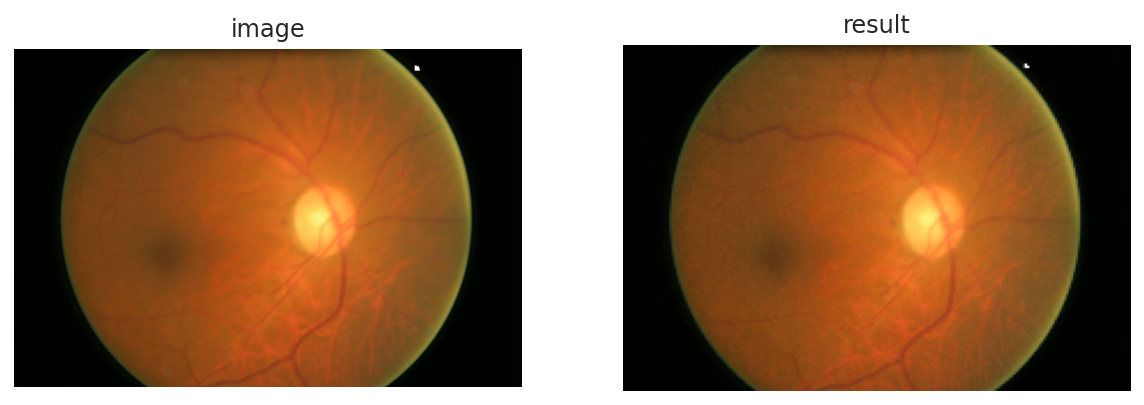

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still have good distinction of optic disc

## Construct Train and Validation datasets

In [13]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (160, 160) # very important to get this right, will determine model success
batch_size = 32

train_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Train/',
    image_size=image_size,
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Validation/',
    image_size=image_size,
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

Found 520 files belonging to 2 classes.
Found 130 files belonging to 2 classes.


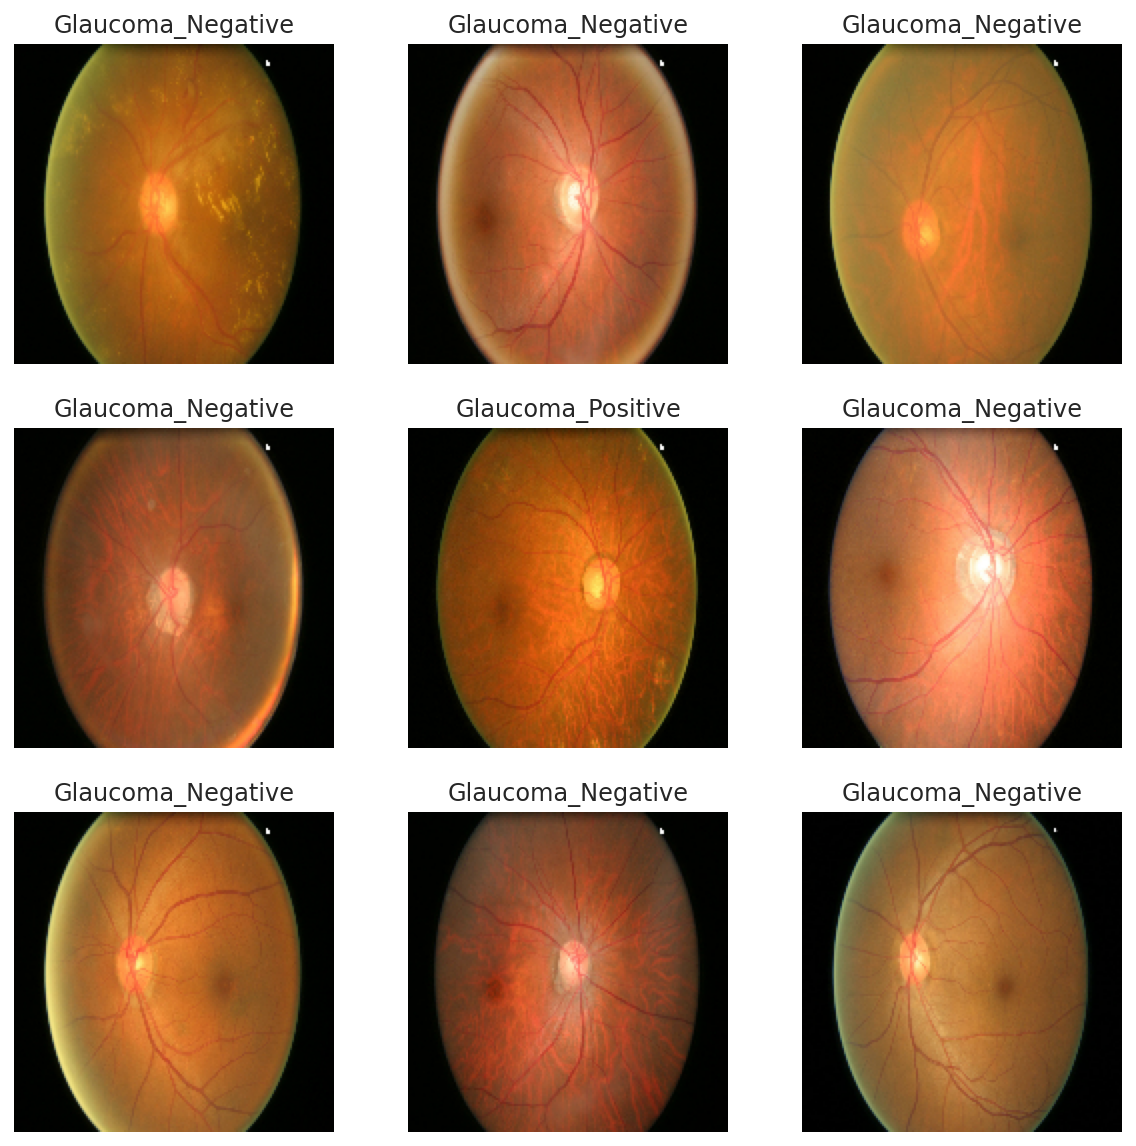

In [14]:
# preview of how images are labelled
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # each image 160 x 160
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create test dataset using 

To do so, I determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [15]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 4
Number of test batches: 1


## Configure datasets for performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

__References:__
1. [Keras.io](https://keras.io/examples/vision/image_classification_from_scratch/)
1. [Tensorflow](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [18]:
data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal_and_vertical", seed=42), 
      layers.RandomRotation(0.2, seed=42),
      layers.RandomContrast(0.1, seed=42)
    ])

Visualize what augmented images look like, applying `data_augmentation` repeatedly to the first image in the train dataset

In [20]:
# preview of how images are augmented
def augmented_img():
  for image, _ in train_ds.take(1): 
    plt.figure(figsize=(8, 8))
    first_image = image[0]
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      plt.imshow(augmented_image[0] / 255) # rescale pixel 0 to 1
      plt.axis("off")

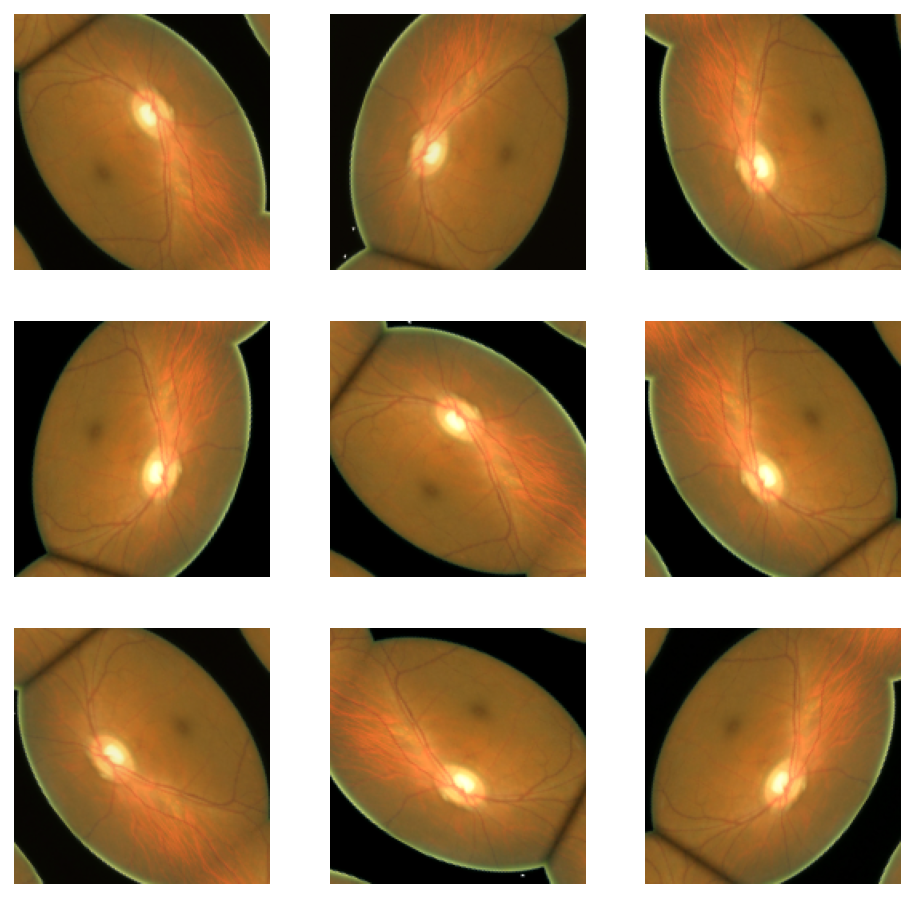

In [21]:
augmented_img()

## Rescale pixel values for model

I will use `tf.keras.applications.MobileNetV2` for use as my base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create base model using Transfer learning from pre-trained convnets

In [23]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [24]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature Extraction

In [26]:
base_model.trainable = False

In [27]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

#### Add a Classification layer

Generate predictions from the block of features, average over the spatial 5x5 spatial locations, using `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image.

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [29]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Build the model

Chain together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [30]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [31]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), # using Adam
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in **MobileNet** are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [33]:
len(model.trainable_variables)

2

## Train the model

In [34]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds) # only 4 batches in val_ds

4/4 [==============================] - 5s 341ms/step - loss: 0.7131 - accuracy: 0.6531


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.65


In [36]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
17/17 [==============================] - 26s 993ms/step - loss: 0.7756 - accuracy: 0.6231 - val_loss: 0.6597 - val_accuracy: 0.7245
Epoch 2/10
17/17 [==============================] - 22s 999ms/step - loss: 0.6796 - accuracy: 0.7192 - val_loss: 0.7594 - val_accuracy: 0.7245
Epoch 3/10
17/17 [==============================] - 25s 1s/step - loss: 0.6411 - accuracy: 0.7096 - val_loss: 0.7435 - val_accuracy: 0.7347
Epoch 4/10
17/17 [==============================] - 22s 991ms/step - loss: 0.6063 - accuracy: 0.7346 - val_loss: 0.8437 - val_accuracy: 0.7041
Epoch 5/10
17/17 [==============================] - 22s 998ms/step - loss: 0.5791 - accuracy: 0.7385 - val_loss: 0.7259 - val_accuracy: 0.7347
Epoch 6/10
17/17 [==============================] - 22s 985ms/step - loss: 0.6118 - accuracy: 0.7462 - val_loss: 0.6931 - val_accuracy: 0.7551
Epoch 7/10
17/17 [==============================] - 22s 1s/step - loss: 0.5977 - accuracy: 0.7423 - val_loss: 0.6973 - val_accuracy: 0.7347
Epoch

## Learning curves

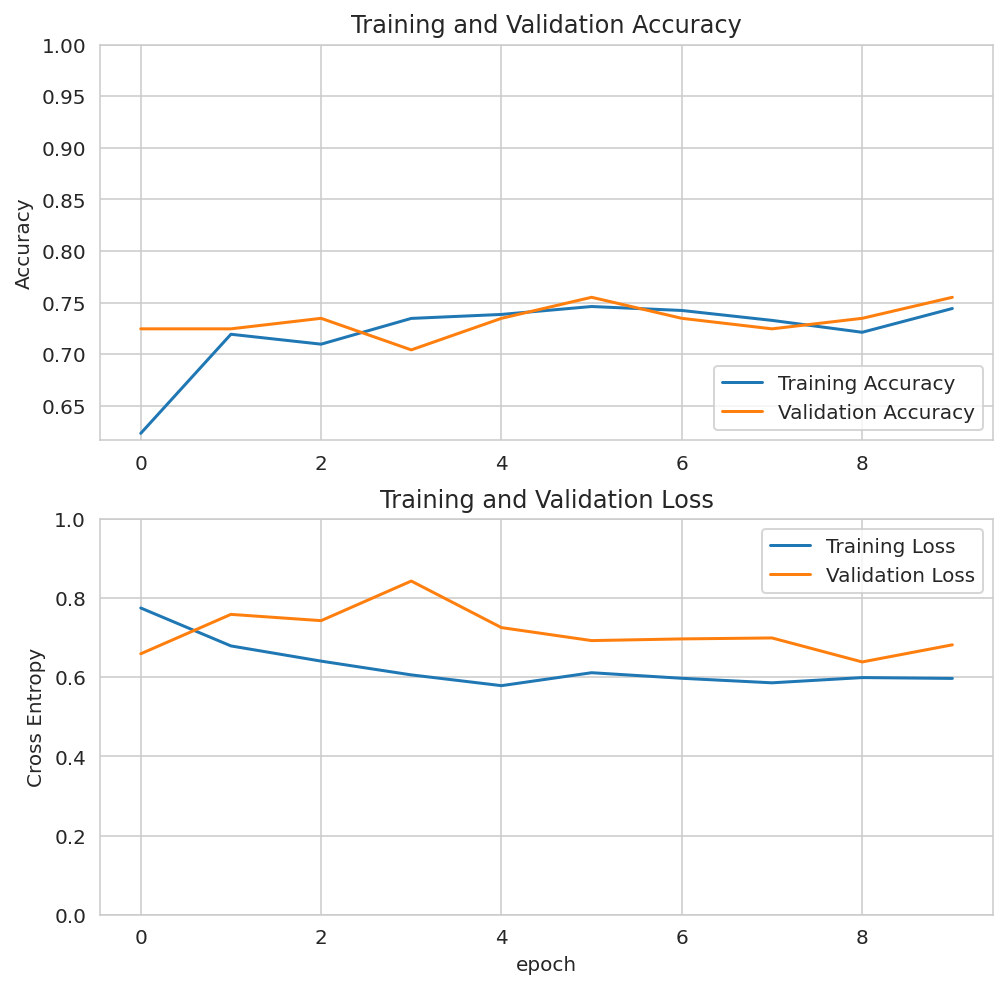

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Finetune model

#### Get Contours of image
[Reference](https://pythonexamples.org/python-opencv-cv2-find-contours-in-image/)

In [ ]:
# Import the library OpenCV
import cv2
from google.colab.patches import cv2_imshow # to stabilise cv2.imshow() function

def retina_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=30
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)
  
  # if needed, to save image
  # cv2.imwrite("contours.jpg", img_contours)

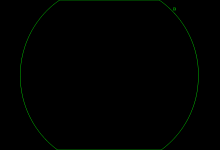

In [ ]:
retina_contour()

In [ ]:
def disc_contour():    
  # Read the image
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', -1) # imread_unchanged
  
  # Convert image to grayscale
  img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # generates grayscale image

  # set thresh # this needs guessing for desired contours
  thresh=155
  # get threshold image
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  
  #find contours
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #create an empty image for contours
  img_contours = np.zeros(img.shape)

  # draw the contours on the empty image
  cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
  
  cv2_imshow(cv2.resize(img_contours, (220, 150), interpolation=cv2.INTER_AREA)) # resize the image for less file space
  #cv2_imshow(img_contours)
  
  # if needed, to save image
  # cv2.imwrite("contours.jpg", img_contours)

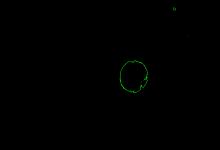

In [ ]:
disc_contour()

### Using WaterShed Algorithm to segment out retina from black background

__References:__
1. [OpenCV WaterShed](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)
2. [GeeksforGeeks](https://www.geeksforgeeks.org/removing-black-background-and-make-transparent-using-python-opencv/)

In [ ]:
def mask():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cv2_imshow(cv2.resize(thresh, (220, 150), interpolation=cv2.INTER_AREA))
  return thresh

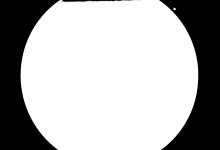

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
mask()
# black region shows background
# white region shows foreground

In [ ]:
def remove_bg():
  img = cv2.imread('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, alpha = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  
  b, g, r = cv2.split(img) # Using cv2.split() to split channels
  
  rgba = [b, g, r, alpha] # Making list of Red, Green, Blue channels and alpha

  new_img = cv2.merge(rgba, 4)

  cv2_imshow(cv2.resize(new_img, (220, 150), interpolation=cv2.INTER_AREA))
  # if needed, save image
  cv2.imwrite("./GA_Capstone/EDA/no_bg.png", new_img) # jpg does not support alpha channel, only png or tiff format
  return new_img

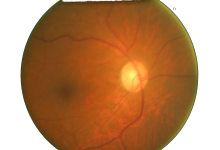

array([[0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       ...,
       [0, 3, 1, 0],
       [0, 3, 1, 0],
       [0, 3, 1, 0]], dtype=uint8)

In [ ]:
remove_bg()[0] # this image has 4 channels

In [ ]:
# try augmentation again
# on removed background image
image2 = cv2.imread('./GA_Capstone/EDA/no_bg.png', cv2.IMREAD_UNCHANGED)
print(image2.shape) # 4 channels
pixels2 = np.asarray(image2) # show numpy array format

print(pixels2[0])

(2048, 3072, 4)
[[0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]
 ...
 [0 3 1 0]
 [0 3 1 0]
 [0 3 1 0]]


In [ ]:
def augmented_imgs():
  plt.figure(figsize=(8, 8))
  img = tf.io.read_file("./GA_Capstone/EDA/no_bg.png")
  # convert to tensor
  tensor = tf.io.decode_image(img, channels=4, dtype=tf.dtypes.float32)
  # resize tensor to 255 x 255
  tensor = tf.image.resize(tensor, [255, 255]) # tensor.shape # (255, 255, 4)
  # add another dimension at the front to get NHWC shape
  input_tensor = tf.expand_dims(tensor, axis=0) #input_tensor.shape (1, 255, 255, 4)
  for i in range(9):
    augmented_image = data_augmentation(input_tensor)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("float32")) # to be same as tf.dataset object type
    # float32 tensors
    plt.axis("off")

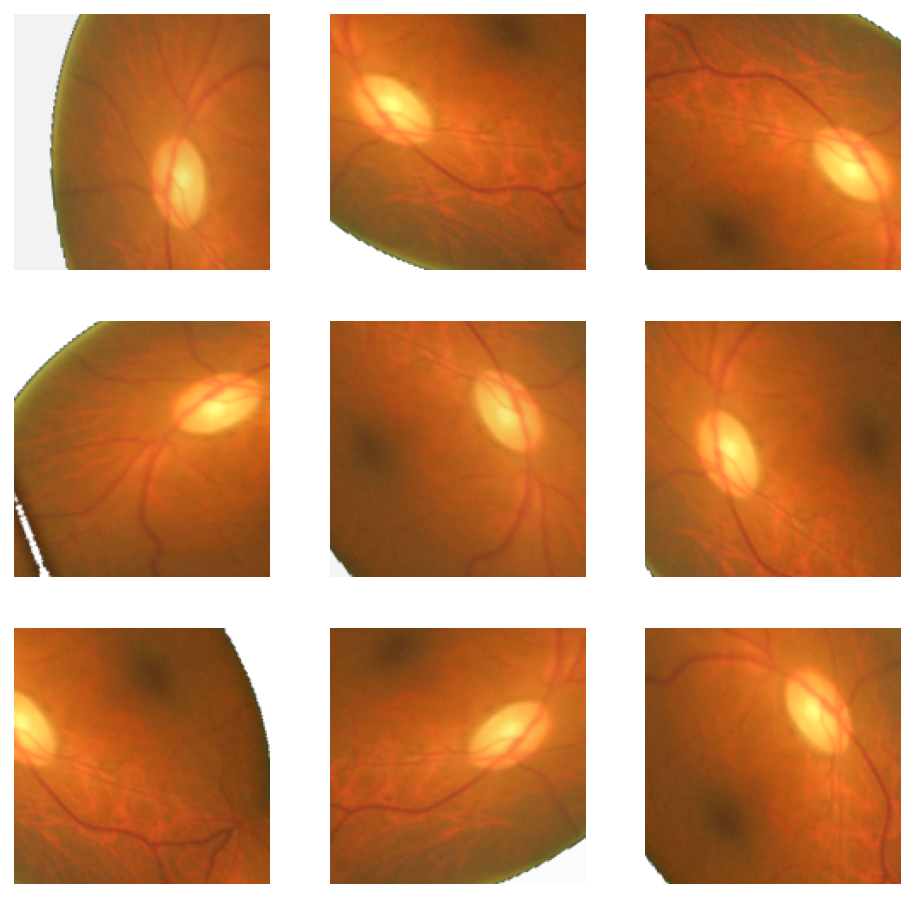

In [ ]:
augmented_imgs()

Comparing augmentation on before and after removing black background from images:
* it appears that by removing the black background, images become more distorted by augmentation. This might not be a good thing for my use case since proportion of optic disc is important for diagnosis of glaucoma. 
* Then again, with the distortion, there may be an exaggeration of proportions, which could help machine learning differentiate better between classes.
* However, I will attempt with baseline images for model with basic data augmentation and batch normalization in the model pipeline first. If there is time, will convert all images without background, and teach the model with the new images.

# UNet structure
<img src="https://miro.medium.com/max/1050/1*1Q3ODFV_t2WVXvm_09ExjA.png" width="400" height="250"> 

__Reference:__
* [UNet architecture](https://blog.paperspace.com/unet-architecture-image-segmentation/)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Dropout
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [ ]:
image_size = (256,256)
model = u_net(image_size = image_size, n_classes = 2)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 256, 256, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_86 (Conv2D)             (None, 256, 256, 16  448         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("saved_epoch_{epoch}.h5", save_best_only=True)
]

model.compile(optimizer="rmsprop", 
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
%%time

model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, verbose=1)

Epoch 1/15


InvalidArgumentError: ignored

# ResNet

# DenseNet